<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in ./venv/lib/python3.6/site-packages (2.2.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras import optimizers


import pandas
import matplotlib.pyplot as plt
# from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [3]:
# drive.mount(ROOT)
# HOME = join(ROOT,'My Drive')
# print('enter the environment directory')
# directory = input()
COLAB_DIR = '.'
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

In [4]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## **Visualization Task**

**Let's do some visualizations first to investigate data set we are working with**

In [10]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


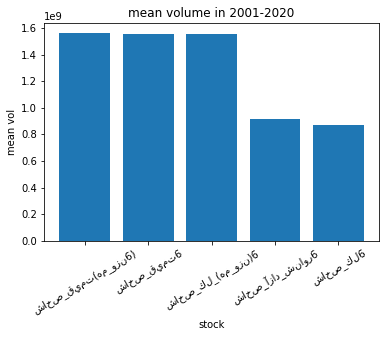

In [11]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [12]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),2015-02-24,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),2015-02-25,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),2015-02-28,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),2015-03-01,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),2015-03-02,9034.4,9043.5,9034.4,9043.5,717632564


In [112]:
import matplotlib.dates as mdates

def draw_ochlv(data_related_to_stock, from_date, to_date):
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    fig.tight_layout()

    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)

    mask = (data_related_to_stock['DATE'] >= from_date) & (data_related_to_stock['DATE'] <= to_date ) 
    period = data_related_to_stock.loc[mask]
    
    starting_date = str(from_date)
    ending_date = str(to_date)

    axs[0][0].plot(period['DATE'], period['CLOSE'])
    axs[0][0].set(ylabel='closing price (in tomans)')
    axs[0][0].set_title('closing price')
    
    axs[1][0].plot(period['DATE'], period['OPEN'])
    axs[1][0].set(ylabel='opening price (in tomans)')
    axs[1][0].set_title('opening price')
                     
    
    axs[0][1].plot(period['DATE'], period['VOL'])
    axs[0][1].set(ylabel='daily volume traded (in share)')
    axs[0][1].set_title('daily volume')
                     
    
    axs[1][1].plot(period['DATE'], period['HIGH'])
    axs[1][1].set(ylabel='high price (in tomans)')
    axs[1][1].set_title('high price')
                     
    axs[2][0].plot(period['DATE'], period['LOW'])
    axs[2][0].set(ylabel='low price (in tomans)')
    axs[2][0].set_title('low price')

    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[2][0].grid(True)

    ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()

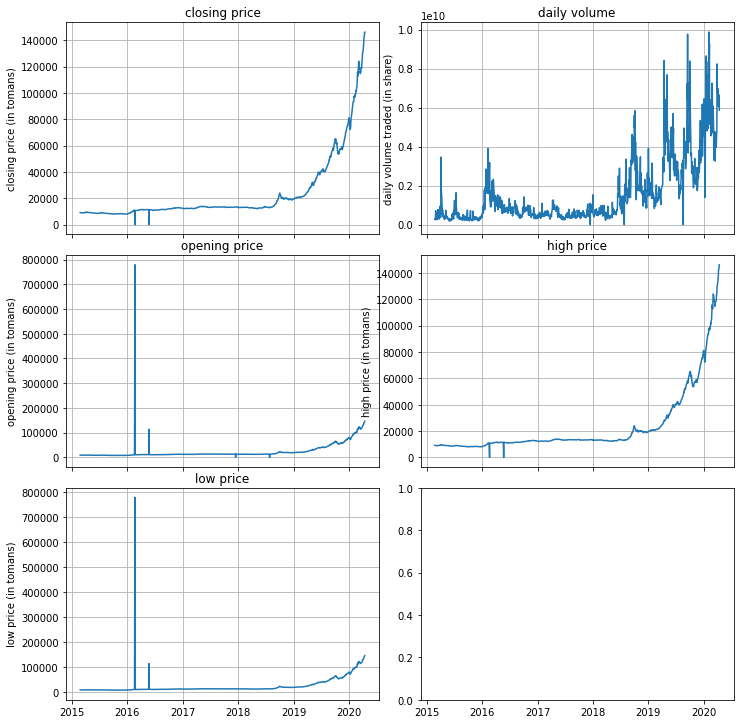

In [117]:
starting_date = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
ending_date = pandas.to_datetime('20200413', format='%Y%m%d', errors='ignore')
draw_ochlv(data_for_ticker_with_max_mean_vol, starting_date, ending_date)

In [14]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Stateful LSTM**

In this section, we train our model on the stock with max trading days. first of all, let's visualize the train and test set of our models.

In [118]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

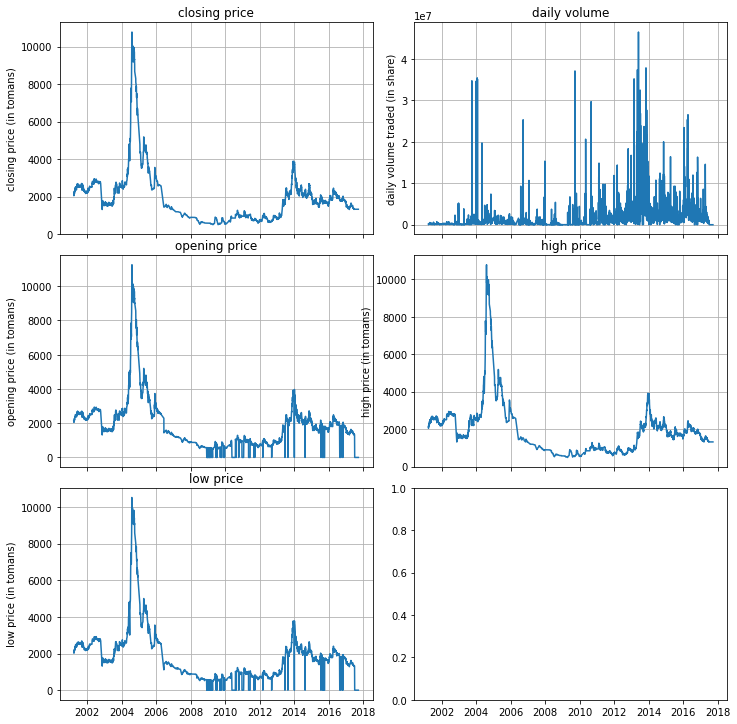

In [114]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, training_start, training_end)

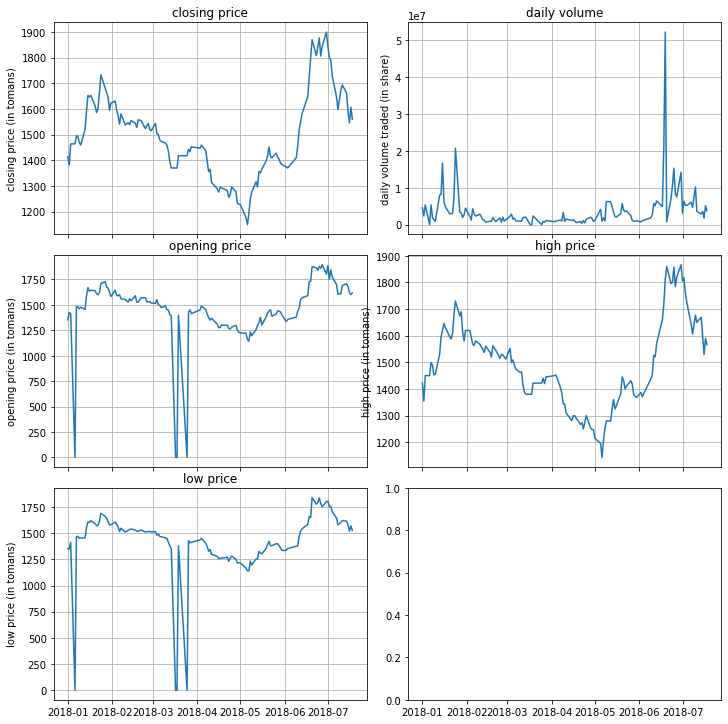

In [115]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, testing_start, testing_end)

Now, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 10.

In [164]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 10, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 10, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

In [165]:
testing_period['DATE'].reset_index(drop=True).tail(50)

120    2018-05-05 00:00:00
121    2018-05-06 00:00:00
122    2018-05-07 00:00:00
123    2018-05-08 00:00:00
124    2018-05-09 00:00:00
125    2018-05-12 00:00:00
126    2018-05-13 00:00:00
127    2018-05-14 00:00:00
128    2018-05-15 00:00:00
129    2018-05-16 00:00:00
130    2018-05-19 00:00:00
131    2018-05-20 00:00:00
132    2018-05-21 00:00:00
133    2018-05-22 00:00:00
134    2018-05-23 00:00:00
135    2018-05-26 00:00:00
136    2018-05-27 00:00:00
137    2018-05-28 00:00:00
138    2018-05-29 00:00:00
139    2018-05-30 00:00:00
140    2018-06-02 00:00:00
141    2018-06-03 00:00:00
142    2018-06-09 00:00:00
143    2018-06-10 00:00:00
144    2018-06-11 00:00:00
145    2018-06-12 00:00:00
146    2018-06-13 00:00:00
147    2018-06-17 00:00:00
148    2018-06-18 00:00:00
149    2018-06-19 00:00:00
150    2018-06-20 00:00:00
151    2018-06-23 00:00:00
152    2018-06-24 00:00:00
153    2018-06-25 00:00:00
154    2018-06-26 00:00:00
155    2018-06-27 00:00:00
156    2018-06-30 00:00:00
1

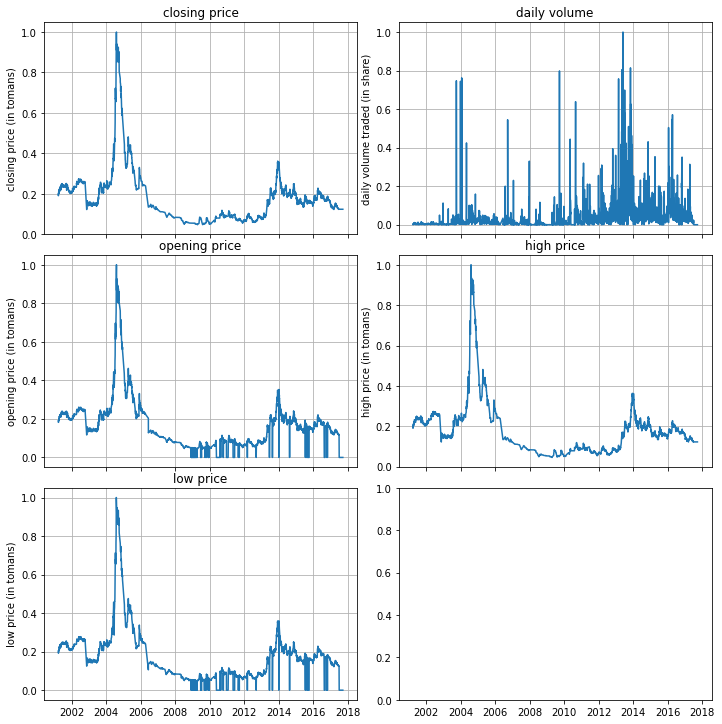

In [155]:
draw_ochlv(_training_period, training_start, training_end)

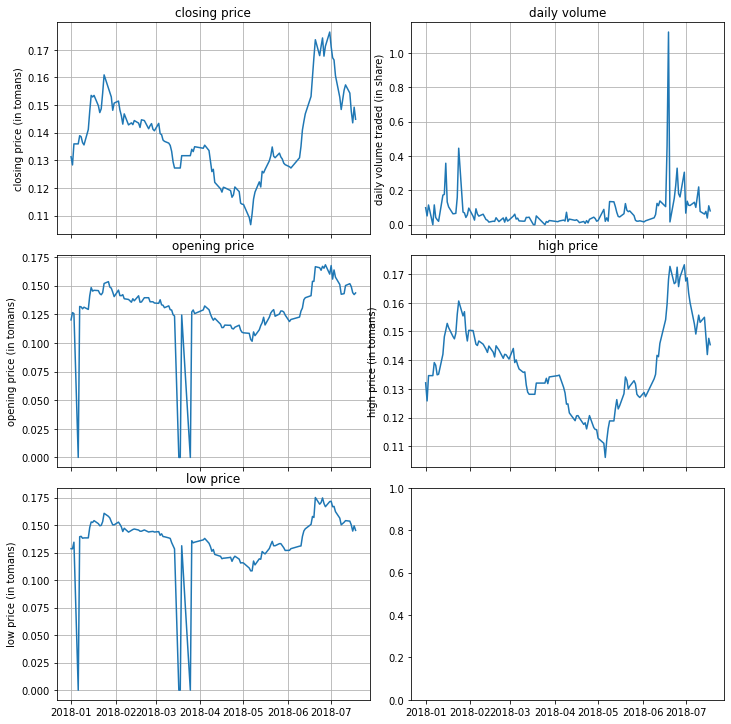

In [166]:
draw_ochlv(_testing_period, testing_start, testing_end)

So, the normalization is really suitable for this dataset.

**Now it is time to start training our model**

We use adam optimizer throughout this experiment.

In [122]:
from numpy.random import uniform

window_in_days = 10

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),\
                                                      len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros(\
                                                     (window_in_days+(batch_size - len(x) % batch_size), \
                                                      len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), \
        pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, \
                             training_start, training_end, testing_start, testing_end, \
                             test_required=True, drop_date=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) \
    & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period = training_period.drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)
  if drop_date:
        training_period_labels.drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) \
        & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period = testing_period_labels.drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period_labels = testing_period_labels.drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df


def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels \
    = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                , testing_start, testing_end, test_required)

  training_period, training_period_labels = align_data(training_period, \
                                                       training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, \
                                                       testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [16]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [18]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [19]:
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class MyLogger(Callback):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [20]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

In [21]:
def tabular_test_train_results(train_results, test_results):
    rows = ['train', 'test']
    columns = [metric for metric in test_results]
    table_data = [ [str(train_results[metric]) for metric in train_results],\
            [str(test_results[metric]) for metric in test_results]]
    table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      rowLoc='center',
                      )
    plt.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(2, 8)
    plt.show()

In [22]:
def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

Now, we want to train the model using different window sizes to see the effect on the performance of the model. Throughout the document, we also report true positive rate, false positive rate, positive precision and negative precision.

Let's start with window size of 10.

In [69]:
epochs = 5000

In [70]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [71]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_24 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_6 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_25 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_6 (Batch (32, 16)                  64        
_________________________________________________________________
dense_26 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_27 (Dense)             (32, 1)                  

In [72]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.770 seconds , loss : 0.703    accuracy : 0.559    
epoch 2
----------->> Epoch 1/1   0.365 seconds , loss : 0.673    accuracy : 0.604    
epoch 3
----------->> Epoch 1/1   0.364 seconds , loss : 0.669    accuracy : 0.608    
epoch 4
----------->> Epoch 1/1   0.346 seconds , loss : 0.665    accuracy : 0.616    
epoch 5
----------->> Epoch 1/1   0.376 seconds , loss : 0.666    accuracy : 0.609    
epoch 6
----------->> Epoch 1/1   0.375 seconds , loss : 0.663    accuracy : 0.613    
epoch 7
----------->> Epoch 1/1   0.365 seconds , loss : 0.663    accuracy : 0.614    
epoch 8
----------->> Epoch 1/1   0.383 seconds , loss : 0.662    accuracy : 0.611    
epoch 9
----------->> Epoch 1/1   0.372 seconds , loss : 0.660    accuracy : 0.617    
epoch 10
----------->> Epoch 1/1   0.496 seconds , loss : 0.661    accuracy : 0.615    
epoch 11
----------->> Epoch 1/1   0.465 seconds , loss : 0.659    accuracy : 0.617    
epoch 12
----------->> Epoch 1/1   0.463 

----------->> Epoch 1/1   0.438 seconds , loss : 0.643    accuracy : 0.636    
epoch 95
----------->> Epoch 1/1   0.450 seconds , loss : 0.641    accuracy : 0.641    
epoch 96
----------->> Epoch 1/1   0.505 seconds , loss : 0.643    accuracy : 0.633    
epoch 97
----------->> Epoch 1/1   0.416 seconds , loss : 0.640    accuracy : 0.636    
epoch 98
----------->> Epoch 1/1   0.465 seconds , loss : 0.641    accuracy : 0.642    
epoch 99
----------->> Epoch 1/1   0.492 seconds , loss : 0.641    accuracy : 0.636    
epoch 100
----------->> Epoch 1/1   0.467 seconds , loss : 0.640    accuracy : 0.641    
epoch 101
----------->> Epoch 1/1   0.488 seconds , loss : 0.640    accuracy : 0.645    
epoch 102
----------->> Epoch 1/1   0.455 seconds , loss : 0.638    accuracy : 0.644    
epoch 103
----------->> Epoch 1/1   0.471 seconds , loss : 0.645    accuracy : 0.640    
epoch 104
----------->> Epoch 1/1   0.473 seconds , loss : 0.637    accuracy : 0.640    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.456 seconds , loss : 0.606    accuracy : 0.680    
epoch 187
----------->> Epoch 1/1   0.425 seconds , loss : 0.607    accuracy : 0.691    
epoch 188
----------->> Epoch 1/1   0.434 seconds , loss : 0.610    accuracy : 0.682    
epoch 189
----------->> Epoch 1/1   0.430 seconds , loss : 0.609    accuracy : 0.684    
epoch 190
----------->> Epoch 1/1   0.477 seconds , loss : 0.605    accuracy : 0.687    
epoch 191
----------->> Epoch 1/1   0.457 seconds , loss : 0.604    accuracy : 0.688    
epoch 192
----------->> Epoch 1/1   0.477 seconds , loss : 0.607    accuracy : 0.688    
epoch 193
----------->> Epoch 1/1   0.454 seconds , loss : 0.608    accuracy : 0.686    
epoch 194
----------->> Epoch 1/1   0.437 seconds , loss : 0.604    accuracy : 0.679    
epoch 195
----------->> Epoch 1/1   0.498 seconds , loss : 0.606    accuracy : 0.688    
epoch 196
----------->> Epoch 1/1   0.451 seconds , loss : 0.602    accuracy : 0.684    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.424 seconds , loss : 0.571    accuracy : 0.708    
epoch 279
----------->> Epoch 1/1   0.431 seconds , loss : 0.571    accuracy : 0.708    
epoch 280
----------->> Epoch 1/1   0.436 seconds , loss : 0.566    accuracy : 0.707    
epoch 281
----------->> Epoch 1/1   0.435 seconds , loss : 0.567    accuracy : 0.704    
epoch 282
----------->> Epoch 1/1   0.429 seconds , loss : 0.572    accuracy : 0.706    
epoch 283
----------->> Epoch 1/1   0.433 seconds , loss : 0.569    accuracy : 0.711    
epoch 284
----------->> Epoch 1/1   0.435 seconds , loss : 0.569    accuracy : 0.708    
epoch 285
----------->> Epoch 1/1   0.420 seconds , loss : 0.570    accuracy : 0.708    
epoch 286
----------->> Epoch 1/1   0.446 seconds , loss : 0.567    accuracy : 0.712    
epoch 287
----------->> Epoch 1/1   0.435 seconds , loss : 0.571    accuracy : 0.703    
epoch 288
----------->> Epoch 1/1   0.423 seconds , loss : 0.567    accuracy : 0.704    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.421 seconds , loss : 0.542    accuracy : 0.720    
epoch 371
----------->> Epoch 1/1   0.434 seconds , loss : 0.544    accuracy : 0.729    
epoch 372
----------->> Epoch 1/1   0.425 seconds , loss : 0.537    accuracy : 0.725    
epoch 373
----------->> Epoch 1/1   0.428 seconds , loss : 0.535    accuracy : 0.725    
epoch 374
----------->> Epoch 1/1   0.439 seconds , loss : 0.539    accuracy : 0.722    
epoch 375
----------->> Epoch 1/1   0.429 seconds , loss : 0.536    accuracy : 0.728    
epoch 376
----------->> Epoch 1/1   0.422 seconds , loss : 0.539    accuracy : 0.726    
epoch 377
----------->> Epoch 1/1   0.427 seconds , loss : 0.534    accuracy : 0.735    
epoch 378
----------->> Epoch 1/1   0.429 seconds , loss : 0.538    accuracy : 0.727    
epoch 379
----------->> Epoch 1/1   0.418 seconds , loss : 0.538    accuracy : 0.729    
epoch 380
----------->> Epoch 1/1   0.431 seconds , loss : 0.533    accuracy : 0.731    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.419 seconds , loss : 0.513    accuracy : 0.747    
epoch 463
----------->> Epoch 1/1   0.423 seconds , loss : 0.509    accuracy : 0.747    
epoch 464
----------->> Epoch 1/1   0.437 seconds , loss : 0.506    accuracy : 0.755    
epoch 465
----------->> Epoch 1/1   0.437 seconds , loss : 0.507    accuracy : 0.748    
epoch 466
----------->> Epoch 1/1   0.414 seconds , loss : 0.506    accuracy : 0.746    
epoch 467
----------->> Epoch 1/1   0.419 seconds , loss : 0.508    accuracy : 0.749    
epoch 468
----------->> Epoch 1/1   0.433 seconds , loss : 0.519    accuracy : 0.740    
epoch 469
----------->> Epoch 1/1   0.409 seconds , loss : 0.509    accuracy : 0.747    
epoch 470
----------->> Epoch 1/1   0.418 seconds , loss : 0.505    accuracy : 0.749    
epoch 471
----------->> Epoch 1/1   0.420 seconds , loss : 0.507    accuracy : 0.742    
epoch 472
----------->> Epoch 1/1   0.413 seconds , loss : 0.505    accuracy : 0.749    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.472 seconds , loss : 0.479    accuracy : 0.766    
epoch 555
----------->> Epoch 1/1   0.392 seconds , loss : 0.486    accuracy : 0.763    
epoch 556
----------->> Epoch 1/1   0.378 seconds , loss : 0.486    accuracy : 0.767    
epoch 557
----------->> Epoch 1/1   0.402 seconds , loss : 0.478    accuracy : 0.769    
epoch 558
----------->> Epoch 1/1   0.441 seconds , loss : 0.486    accuracy : 0.758    
epoch 559
----------->> Epoch 1/1   0.394 seconds , loss : 0.480    accuracy : 0.763    
epoch 560
----------->> Epoch 1/1   0.382 seconds , loss : 0.482    accuracy : 0.764    
epoch 561
----------->> Epoch 1/1   0.379 seconds , loss : 0.477    accuracy : 0.778    
epoch 562
----------->> Epoch 1/1   0.380 seconds , loss : 0.493    accuracy : 0.763    
epoch 563
----------->> Epoch 1/1   0.378 seconds , loss : 0.477    accuracy : 0.768    
epoch 564
----------->> Epoch 1/1   0.382 seconds , loss : 0.486    accuracy : 0.765    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.450 seconds , loss : 0.468    accuracy : 0.781    
epoch 647
----------->> Epoch 1/1   0.428 seconds , loss : 0.462    accuracy : 0.778    
epoch 648
----------->> Epoch 1/1   0.452 seconds , loss : 0.456    accuracy : 0.787    
epoch 649
----------->> Epoch 1/1   0.433 seconds , loss : 0.447    accuracy : 0.791    
epoch 650
----------->> Epoch 1/1   0.434 seconds , loss : 0.461    accuracy : 0.780    
epoch 651
----------->> Epoch 1/1   0.418 seconds , loss : 0.457    accuracy : 0.788    
epoch 652
----------->> Epoch 1/1   0.418 seconds , loss : 0.456    accuracy : 0.786    
epoch 653
----------->> Epoch 1/1   0.421 seconds , loss : 0.457    accuracy : 0.781    
epoch 654
----------->> Epoch 1/1   0.425 seconds , loss : 0.461    accuracy : 0.783    
epoch 655
----------->> Epoch 1/1   0.430 seconds , loss : 0.450    accuracy : 0.791    
epoch 656
----------->> Epoch 1/1   0.427 seconds , loss : 0.467    accuracy : 0.781    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.431 seconds , loss : 0.428    accuracy : 0.797    
epoch 739
----------->> Epoch 1/1   0.449 seconds , loss : 0.429    accuracy : 0.806    
epoch 740
----------->> Epoch 1/1   0.453 seconds , loss : 0.433    accuracy : 0.796    
epoch 741
----------->> Epoch 1/1   0.413 seconds , loss : 0.427    accuracy : 0.801    
epoch 742
----------->> Epoch 1/1   0.397 seconds , loss : 0.435    accuracy : 0.793    
epoch 743
----------->> Epoch 1/1   0.389 seconds , loss : 0.437    accuracy : 0.800    
epoch 744
----------->> Epoch 1/1   0.394 seconds , loss : 0.422    accuracy : 0.800    
epoch 745
----------->> Epoch 1/1   0.419 seconds , loss : 0.422    accuracy : 0.803    
epoch 746
----------->> Epoch 1/1   0.412 seconds , loss : 0.424    accuracy : 0.799    
epoch 747
----------->> Epoch 1/1   0.478 seconds , loss : 0.426    accuracy : 0.803    
epoch 748
----------->> Epoch 1/1   0.474 seconds , loss : 0.431    accuracy : 0.802    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.429 seconds , loss : 0.407    accuracy : 0.811    
epoch 831
----------->> Epoch 1/1   0.532 seconds , loss : 0.408    accuracy : 0.811    
epoch 832
----------->> Epoch 1/1   0.437 seconds , loss : 0.405    accuracy : 0.813    
epoch 833
----------->> Epoch 1/1   0.437 seconds , loss : 0.405    accuracy : 0.815    
epoch 834
----------->> Epoch 1/1   0.426 seconds , loss : 0.409    accuracy : 0.812    
epoch 835
----------->> Epoch 1/1   0.462 seconds , loss : 0.401    accuracy : 0.817    
epoch 836
----------->> Epoch 1/1   0.471 seconds , loss : 0.394    accuracy : 0.814    
epoch 837
----------->> Epoch 1/1   0.487 seconds , loss : 0.400    accuracy : 0.814    
epoch 838
----------->> Epoch 1/1   0.469 seconds , loss : 0.404    accuracy : 0.808    
epoch 839
----------->> Epoch 1/1   0.475 seconds , loss : 0.404    accuracy : 0.812    
epoch 840
----------->> Epoch 1/1   0.473 seconds , loss : 0.405    accuracy : 0.811    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.467 seconds , loss : 0.393    accuracy : 0.816    
epoch 923
----------->> Epoch 1/1   0.481 seconds , loss : 0.382    accuracy : 0.831    
epoch 924
----------->> Epoch 1/1   0.477 seconds , loss : 0.378    accuracy : 0.832    
epoch 925
----------->> Epoch 1/1   0.460 seconds , loss : 0.392    accuracy : 0.819    
epoch 926
----------->> Epoch 1/1   0.472 seconds , loss : 0.386    accuracy : 0.826    
epoch 927
----------->> Epoch 1/1   0.453 seconds , loss : 0.378    accuracy : 0.829    
epoch 928
----------->> Epoch 1/1   0.453 seconds , loss : 0.382    accuracy : 0.824    
epoch 929
----------->> Epoch 1/1   0.458 seconds , loss : 0.388    accuracy : 0.822    
epoch 930
----------->> Epoch 1/1   0.454 seconds , loss : 0.387    accuracy : 0.824    
epoch 931
----------->> Epoch 1/1   0.455 seconds , loss : 0.402    accuracy : 0.816    
epoch 932
----------->> Epoch 1/1   0.447 seconds , loss : 0.395    accuracy : 0.822    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.465 seconds , loss : 0.354    accuracy : 0.842    
epoch 1015
----------->> Epoch 1/1   0.493 seconds , loss : 0.377    accuracy : 0.827    
epoch 1016
----------->> Epoch 1/1   0.568 seconds , loss : 0.364    accuracy : 0.837    
epoch 1017
----------->> Epoch 1/1   0.526 seconds , loss : 0.364    accuracy : 0.841    
epoch 1018
----------->> Epoch 1/1   0.513 seconds , loss : 0.361    accuracy : 0.832    
epoch 1019
----------->> Epoch 1/1   0.486 seconds , loss : 0.366    accuracy : 0.834    
epoch 1020
----------->> Epoch 1/1   0.514 seconds , loss : 0.364    accuracy : 0.839    
epoch 1021
----------->> Epoch 1/1   0.459 seconds , loss : 0.357    accuracy : 0.837    
epoch 1022
----------->> Epoch 1/1   0.507 seconds , loss : 0.362    accuracy : 0.839    
epoch 1023
----------->> Epoch 1/1   0.512 seconds , loss : 0.364    accuracy : 0.828    
epoch 1024
----------->> Epoch 1/1   0.439 seconds , loss : 0.361    accuracy : 0.834    
epoch 1025
----------

----------->> Epoch 1/1   0.449 seconds , loss : 0.346    accuracy : 0.847    
epoch 1106
----------->> Epoch 1/1   0.444 seconds , loss : 0.358    accuracy : 0.842    
epoch 1107
----------->> Epoch 1/1   0.441 seconds , loss : 0.345    accuracy : 0.854    
epoch 1108
----------->> Epoch 1/1   0.438 seconds , loss : 0.346    accuracy : 0.850    
epoch 1109
----------->> Epoch 1/1   0.432 seconds , loss : 0.339    accuracy : 0.845    
epoch 1110
----------->> Epoch 1/1   0.438 seconds , loss : 0.338    accuracy : 0.849    
epoch 1111
----------->> Epoch 1/1   0.435 seconds , loss : 0.336    accuracy : 0.852    
epoch 1112
----------->> Epoch 1/1   0.429 seconds , loss : 0.343    accuracy : 0.844    
epoch 1113
----------->> Epoch 1/1   0.427 seconds , loss : 0.343    accuracy : 0.852    
epoch 1114
----------->> Epoch 1/1   0.432 seconds , loss : 0.340    accuracy : 0.846    
epoch 1115
----------->> Epoch 1/1   0.433 seconds , loss : 0.345    accuracy : 0.845    
epoch 1116
----------

----------->> Epoch 1/1   0.491 seconds , loss : 0.317    accuracy : 0.862    
epoch 1197
----------->> Epoch 1/1   0.460 seconds , loss : 0.327    accuracy : 0.858    
epoch 1198
----------->> Epoch 1/1   0.438 seconds , loss : 0.325    accuracy : 0.863    
epoch 1199
----------->> Epoch 1/1   0.434 seconds , loss : 0.317    accuracy : 0.865    
epoch 1200
----------->> Epoch 1/1   0.434 seconds , loss : 0.336    accuracy : 0.855    
epoch 1201
----------->> Epoch 1/1   0.431 seconds , loss : 0.322    accuracy : 0.863    
epoch 1202
----------->> Epoch 1/1   0.441 seconds , loss : 0.329    accuracy : 0.859    
epoch 1203
----------->> Epoch 1/1   0.423 seconds , loss : 0.313    accuracy : 0.864    
epoch 1204
----------->> Epoch 1/1   0.432 seconds , loss : 0.337    accuracy : 0.856    
epoch 1205
----------->> Epoch 1/1   0.431 seconds , loss : 0.326    accuracy : 0.862    
epoch 1206
----------->> Epoch 1/1   0.415 seconds , loss : 0.316    accuracy : 0.866    
epoch 1207
----------

----------->> Epoch 1/1   0.407 seconds , loss : 0.306    accuracy : 0.866    
epoch 1288
----------->> Epoch 1/1   0.421 seconds , loss : 0.311    accuracy : 0.868    
epoch 1289
----------->> Epoch 1/1   0.395 seconds , loss : 0.328    accuracy : 0.857    
epoch 1290
----------->> Epoch 1/1   0.425 seconds , loss : 0.323    accuracy : 0.862    
epoch 1291
----------->> Epoch 1/1   0.455 seconds , loss : 0.305    accuracy : 0.869    
epoch 1292
----------->> Epoch 1/1   0.409 seconds , loss : 0.292    accuracy : 0.875    
epoch 1293
----------->> Epoch 1/1   0.400 seconds , loss : 0.302    accuracy : 0.873    
epoch 1294
----------->> Epoch 1/1   0.400 seconds , loss : 0.302    accuracy : 0.870    
epoch 1295
----------->> Epoch 1/1   0.436 seconds , loss : 0.307    accuracy : 0.869    
epoch 1296
----------->> Epoch 1/1   0.436 seconds , loss : 0.319    accuracy : 0.858    
epoch 1297
----------->> Epoch 1/1   0.507 seconds , loss : 0.312    accuracy : 0.867    
epoch 1298
----------

----------->> Epoch 1/1   0.432 seconds , loss : 0.294    accuracy : 0.872    
epoch 1379
----------->> Epoch 1/1   0.431 seconds , loss : 0.298    accuracy : 0.872    
epoch 1380
----------->> Epoch 1/1   0.424 seconds , loss : 0.294    accuracy : 0.878    
epoch 1381
----------->> Epoch 1/1   0.464 seconds , loss : 0.286    accuracy : 0.876    
epoch 1382
----------->> Epoch 1/1   0.467 seconds , loss : 0.285    accuracy : 0.879    
epoch 1383
----------->> Epoch 1/1   0.438 seconds , loss : 0.299    accuracy : 0.872    
epoch 1384
----------->> Epoch 1/1   0.437 seconds , loss : 0.297    accuracy : 0.874    
epoch 1385
----------->> Epoch 1/1   0.441 seconds , loss : 0.304    accuracy : 0.871    
epoch 1386
----------->> Epoch 1/1   0.423 seconds , loss : 0.293    accuracy : 0.876    
epoch 1387
----------->> Epoch 1/1   0.457 seconds , loss : 0.290    accuracy : 0.881    
epoch 1388
----------->> Epoch 1/1   0.441 seconds , loss : 0.296    accuracy : 0.869    
epoch 1389
----------

----------->> Epoch 1/1   0.503 seconds , loss : 0.289    accuracy : 0.883    
epoch 1470
----------->> Epoch 1/1   0.501 seconds , loss : 0.286    accuracy : 0.875    
epoch 1471
----------->> Epoch 1/1   0.492 seconds , loss : 0.286    accuracy : 0.884    
epoch 1472
----------->> Epoch 1/1   0.463 seconds , loss : 0.271    accuracy : 0.884    
epoch 1473
----------->> Epoch 1/1   0.455 seconds , loss : 0.292    accuracy : 0.878    
epoch 1474
----------->> Epoch 1/1   0.447 seconds , loss : 0.293    accuracy : 0.871    
epoch 1475
----------->> Epoch 1/1   0.439 seconds , loss : 0.291    accuracy : 0.874    
epoch 1476
----------->> Epoch 1/1   0.488 seconds , loss : 0.287    accuracy : 0.880    
epoch 1477
----------->> Epoch 1/1   0.502 seconds , loss : 0.274    accuracy : 0.886    
epoch 1478
----------->> Epoch 1/1   0.492 seconds , loss : 0.273    accuracy : 0.881    
epoch 1479
----------->> Epoch 1/1   0.479 seconds , loss : 0.282    accuracy : 0.878    
epoch 1480
----------

----------->> Epoch 1/1   0.444 seconds , loss : 0.253    accuracy : 0.896    
epoch 1561
----------->> Epoch 1/1   0.466 seconds , loss : 0.267    accuracy : 0.890    
epoch 1562
----------->> Epoch 1/1   0.522 seconds , loss : 0.271    accuracy : 0.886    
epoch 1563
----------->> Epoch 1/1   0.468 seconds , loss : 0.263    accuracy : 0.886    
epoch 1564
----------->> Epoch 1/1   0.406 seconds , loss : 0.273    accuracy : 0.886    
epoch 1565
----------->> Epoch 1/1   0.459 seconds , loss : 0.263    accuracy : 0.894    
epoch 1566
----------->> Epoch 1/1   0.528 seconds , loss : 0.260    accuracy : 0.890    
epoch 1567
----------->> Epoch 1/1   0.520 seconds , loss : 0.254    accuracy : 0.893    
epoch 1568
----------->> Epoch 1/1   0.460 seconds , loss : 0.278    accuracy : 0.887    
epoch 1569
----------->> Epoch 1/1   0.433 seconds , loss : 0.271    accuracy : 0.891    
epoch 1570
----------->> Epoch 1/1   0.561 seconds , loss : 0.265    accuracy : 0.889    
epoch 1571
----------

----------->> Epoch 1/1   0.420 seconds , loss : 0.257    accuracy : 0.894    
epoch 1652
----------->> Epoch 1/1   0.413 seconds , loss : 0.246    accuracy : 0.901    
epoch 1653
----------->> Epoch 1/1   0.405 seconds , loss : 0.256    accuracy : 0.896    
epoch 1654
----------->> Epoch 1/1   0.403 seconds , loss : 0.250    accuracy : 0.898    
epoch 1655
----------->> Epoch 1/1   0.440 seconds , loss : 0.264    accuracy : 0.887    
epoch 1656
----------->> Epoch 1/1   0.473 seconds , loss : 0.260    accuracy : 0.888    
epoch 1657
----------->> Epoch 1/1   0.451 seconds , loss : 0.258    accuracy : 0.893    
epoch 1658
----------->> Epoch 1/1   0.458 seconds , loss : 0.242    accuracy : 0.901    
epoch 1659
----------->> Epoch 1/1   0.456 seconds , loss : 0.250    accuracy : 0.894    
epoch 1660
----------->> Epoch 1/1   0.434 seconds , loss : 0.245    accuracy : 0.901    
epoch 1661
----------->> Epoch 1/1   0.485 seconds , loss : 0.249    accuracy : 0.899    
epoch 1662
----------

----------->> Epoch 1/1   0.485 seconds , loss : 0.237    accuracy : 0.906    
epoch 1743
----------->> Epoch 1/1   0.441 seconds , loss : 0.248    accuracy : 0.897    
epoch 1744
----------->> Epoch 1/1   0.437 seconds , loss : 0.256    accuracy : 0.892    
epoch 1745
----------->> Epoch 1/1   0.475 seconds , loss : 0.250    accuracy : 0.900    
epoch 1746
----------->> Epoch 1/1   0.401 seconds , loss : 0.245    accuracy : 0.899    
epoch 1747
----------->> Epoch 1/1   0.402 seconds , loss : 0.240    accuracy : 0.899    
epoch 1748
----------->> Epoch 1/1   0.397 seconds , loss : 0.231    accuracy : 0.905    
epoch 1749
----------->> Epoch 1/1   0.424 seconds , loss : 0.234    accuracy : 0.903    
epoch 1750
----------->> Epoch 1/1   0.424 seconds , loss : 0.252    accuracy : 0.894    
epoch 1751
----------->> Epoch 1/1   0.394 seconds , loss : 0.245    accuracy : 0.899    
epoch 1752
----------->> Epoch 1/1   0.391 seconds , loss : 0.248    accuracy : 0.904    
epoch 1753
----------

----------->> Epoch 1/1   0.465 seconds , loss : 0.229    accuracy : 0.908    
epoch 1834
----------->> Epoch 1/1   0.439 seconds , loss : 0.224    accuracy : 0.913    
epoch 1835
----------->> Epoch 1/1   0.453 seconds , loss : 0.230    accuracy : 0.909    
epoch 1836
----------->> Epoch 1/1   0.465 seconds , loss : 0.224    accuracy : 0.907    
epoch 1837
----------->> Epoch 1/1   0.450 seconds , loss : 0.228    accuracy : 0.909    
epoch 1838
----------->> Epoch 1/1   0.455 seconds , loss : 0.238    accuracy : 0.901    
epoch 1839
----------->> Epoch 1/1   0.458 seconds , loss : 0.234    accuracy : 0.905    
epoch 1840
----------->> Epoch 1/1   0.464 seconds , loss : 0.237    accuracy : 0.909    
epoch 1841
----------->> Epoch 1/1   0.488 seconds , loss : 0.234    accuracy : 0.904    
epoch 1842
----------->> Epoch 1/1   0.502 seconds , loss : 0.224    accuracy : 0.911    
epoch 1843
----------->> Epoch 1/1   0.464 seconds , loss : 0.238    accuracy : 0.900    
epoch 1844
----------

----------->> Epoch 1/1   0.443 seconds , loss : 0.238    accuracy : 0.910    
epoch 1925
----------->> Epoch 1/1   0.439 seconds , loss : 0.248    accuracy : 0.897    
epoch 1926
----------->> Epoch 1/1   0.430 seconds , loss : 0.222    accuracy : 0.914    
epoch 1927
----------->> Epoch 1/1   0.427 seconds , loss : 0.222    accuracy : 0.912    
epoch 1928
----------->> Epoch 1/1   0.423 seconds , loss : 0.229    accuracy : 0.907    
epoch 1929
----------->> Epoch 1/1   0.428 seconds , loss : 0.225    accuracy : 0.909    
epoch 1930
----------->> Epoch 1/1   0.424 seconds , loss : 0.231    accuracy : 0.906    
epoch 1931
----------->> Epoch 1/1   0.422 seconds , loss : 0.218    accuracy : 0.911    
epoch 1932
----------->> Epoch 1/1   0.431 seconds , loss : 0.215    accuracy : 0.914    
epoch 1933
----------->> Epoch 1/1   0.428 seconds , loss : 0.211    accuracy : 0.912    
epoch 1934
----------->> Epoch 1/1   0.431 seconds , loss : 0.219    accuracy : 0.918    
epoch 1935
----------

----------->> Epoch 1/1   0.418 seconds , loss : 0.209    accuracy : 0.917    
epoch 2016
----------->> Epoch 1/1   0.423 seconds , loss : 0.207    accuracy : 0.916    
epoch 2017
----------->> Epoch 1/1   0.477 seconds , loss : 0.201    accuracy : 0.917    
epoch 2018
----------->> Epoch 1/1   0.506 seconds , loss : 0.215    accuracy : 0.913    
epoch 2019
----------->> Epoch 1/1   0.494 seconds , loss : 0.211    accuracy : 0.910    
epoch 2020
----------->> Epoch 1/1   0.469 seconds , loss : 0.214    accuracy : 0.912    
epoch 2021
----------->> Epoch 1/1   0.422 seconds , loss : 0.211    accuracy : 0.915    
epoch 2022
----------->> Epoch 1/1   0.496 seconds , loss : 0.198    accuracy : 0.916    
epoch 2023
----------->> Epoch 1/1   0.452 seconds , loss : 0.218    accuracy : 0.912    
epoch 2024
----------->> Epoch 1/1   0.451 seconds , loss : 0.210    accuracy : 0.914    
epoch 2025
----------->> Epoch 1/1   0.441 seconds , loss : 0.206    accuracy : 0.917    
epoch 2026
----------

----------->> Epoch 1/1   0.451 seconds , loss : 0.194    accuracy : 0.925    
epoch 2107
----------->> Epoch 1/1   0.449 seconds , loss : 0.195    accuracy : 0.926    
epoch 2108
----------->> Epoch 1/1   0.492 seconds , loss : 0.202    accuracy : 0.918    
epoch 2109
----------->> Epoch 1/1   0.445 seconds , loss : 0.194    accuracy : 0.922    
epoch 2110
----------->> Epoch 1/1   0.435 seconds , loss : 0.212    accuracy : 0.913    
epoch 2111
----------->> Epoch 1/1   0.431 seconds , loss : 0.215    accuracy : 0.915    
epoch 2112
----------->> Epoch 1/1   0.433 seconds , loss : 0.224    accuracy : 0.917    
epoch 2113
----------->> Epoch 1/1   0.426 seconds , loss : 0.198    accuracy : 0.922    
epoch 2114
----------->> Epoch 1/1   0.421 seconds , loss : 0.188    accuracy : 0.928    
epoch 2115
----------->> Epoch 1/1   0.431 seconds , loss : 0.187    accuracy : 0.926    
epoch 2116
----------->> Epoch 1/1   0.420 seconds , loss : 0.214    accuracy : 0.912    
epoch 2117
----------

----------->> Epoch 1/1   0.451 seconds , loss : 0.183    accuracy : 0.923    
epoch 2198
----------->> Epoch 1/1   0.469 seconds , loss : 0.184    accuracy : 0.931    
epoch 2199
----------->> Epoch 1/1   0.422 seconds , loss : 0.194    accuracy : 0.924    
epoch 2200
----------->> Epoch 1/1   0.467 seconds , loss : 0.195    accuracy : 0.923    
epoch 2201
----------->> Epoch 1/1   0.468 seconds , loss : 0.183    accuracy : 0.928    
epoch 2202
----------->> Epoch 1/1   0.486 seconds , loss : 0.186    accuracy : 0.925    
epoch 2203
----------->> Epoch 1/1   0.433 seconds , loss : 0.185    accuracy : 0.926    
epoch 2204
----------->> Epoch 1/1   0.393 seconds , loss : 0.185    accuracy : 0.927    
epoch 2205
----------->> Epoch 1/1   0.419 seconds , loss : 0.188    accuracy : 0.927    
epoch 2206
----------->> Epoch 1/1   0.413 seconds , loss : 0.199    accuracy : 0.922    
epoch 2207
----------->> Epoch 1/1   0.400 seconds , loss : 0.182    accuracy : 0.930    
epoch 2208
----------

----------->> Epoch 1/1   0.406 seconds , loss : 0.164    accuracy : 0.939    
epoch 2289
----------->> Epoch 1/1   0.413 seconds , loss : 0.172    accuracy : 0.932    
epoch 2290
----------->> Epoch 1/1   0.403 seconds , loss : 0.197    accuracy : 0.924    
epoch 2291
----------->> Epoch 1/1   0.394 seconds , loss : 0.191    accuracy : 0.925    
epoch 2292
----------->> Epoch 1/1   0.399 seconds , loss : 0.184    accuracy : 0.925    
epoch 2293
----------->> Epoch 1/1   0.394 seconds , loss : 0.185    accuracy : 0.928    
epoch 2294
----------->> Epoch 1/1   0.396 seconds , loss : 0.185    accuracy : 0.929    
epoch 2295
----------->> Epoch 1/1   0.451 seconds , loss : 0.205    accuracy : 0.916    
epoch 2296
----------->> Epoch 1/1   0.406 seconds , loss : 0.172    accuracy : 0.931    
epoch 2297
----------->> Epoch 1/1   0.427 seconds , loss : 0.178    accuracy : 0.931    
epoch 2298
----------->> Epoch 1/1   0.421 seconds , loss : 0.181    accuracy : 0.928    
epoch 2299
----------

----------->> Epoch 1/1   0.435 seconds , loss : 0.164    accuracy : 0.936    
epoch 2380
----------->> Epoch 1/1   0.444 seconds , loss : 0.166    accuracy : 0.933    
epoch 2381
----------->> Epoch 1/1   0.428 seconds , loss : 0.163    accuracy : 0.935    
epoch 2382
----------->> Epoch 1/1   0.431 seconds , loss : 0.181    accuracy : 0.929    
epoch 2383
----------->> Epoch 1/1   0.419 seconds , loss : 0.170    accuracy : 0.935    
epoch 2384
----------->> Epoch 1/1   0.430 seconds , loss : 0.174    accuracy : 0.933    
epoch 2385
----------->> Epoch 1/1   0.432 seconds , loss : 0.165    accuracy : 0.939    
epoch 2386
----------->> Epoch 1/1   0.435 seconds , loss : 0.160    accuracy : 0.938    
epoch 2387
----------->> Epoch 1/1   0.428 seconds , loss : 0.157    accuracy : 0.940    
epoch 2388
----------->> Epoch 1/1   0.433 seconds , loss : 0.173    accuracy : 0.936    
epoch 2389
----------->> Epoch 1/1   0.424 seconds , loss : 0.173    accuracy : 0.931    
epoch 2390
----------

----------->> Epoch 1/1   0.416 seconds , loss : 0.156    accuracy : 0.941    
epoch 2471
----------->> Epoch 1/1   0.445 seconds , loss : 0.156    accuracy : 0.939    
epoch 2472
----------->> Epoch 1/1   0.439 seconds , loss : 0.162    accuracy : 0.939    
epoch 2473
----------->> Epoch 1/1   0.446 seconds , loss : 0.166    accuracy : 0.935    
epoch 2474
----------->> Epoch 1/1   0.497 seconds , loss : 0.168    accuracy : 0.938    
epoch 2475
----------->> Epoch 1/1   0.598 seconds , loss : 0.154    accuracy : 0.944    
epoch 2476
----------->> Epoch 1/1   0.504 seconds , loss : 0.164    accuracy : 0.939    
epoch 2477
----------->> Epoch 1/1   0.488 seconds , loss : 0.161    accuracy : 0.941    
epoch 2478
----------->> Epoch 1/1   0.435 seconds , loss : 0.175    accuracy : 0.932    
epoch 2479
----------->> Epoch 1/1   0.433 seconds , loss : 0.149    accuracy : 0.940    
epoch 2480
----------->> Epoch 1/1   0.531 seconds , loss : 0.141    accuracy : 0.950    
epoch 2481
----------

----------->> Epoch 1/1   0.457 seconds , loss : 0.181    accuracy : 0.937    
epoch 2562
----------->> Epoch 1/1   0.427 seconds , loss : 0.161    accuracy : 0.940    
epoch 2563
----------->> Epoch 1/1   0.466 seconds , loss : 0.149    accuracy : 0.947    
epoch 2564
----------->> Epoch 1/1   0.459 seconds , loss : 0.151    accuracy : 0.939    
epoch 2565
----------->> Epoch 1/1   0.496 seconds , loss : 0.147    accuracy : 0.943    
epoch 2566
----------->> Epoch 1/1   0.467 seconds , loss : 0.146    accuracy : 0.944    
epoch 2567
----------->> Epoch 1/1   0.398 seconds , loss : 0.149    accuracy : 0.946    
epoch 2568
----------->> Epoch 1/1   0.395 seconds , loss : 0.140    accuracy : 0.949    
epoch 2569
----------->> Epoch 1/1   0.441 seconds , loss : 0.147    accuracy : 0.945    
epoch 2570
----------->> Epoch 1/1   0.431 seconds , loss : 0.138    accuracy : 0.949    
epoch 2571
----------->> Epoch 1/1   0.413 seconds , loss : 0.147    accuracy : 0.945    
epoch 2572
----------

----------->> Epoch 1/1   0.451 seconds , loss : 0.134    accuracy : 0.949    
epoch 2653
----------->> Epoch 1/1   0.397 seconds , loss : 0.121    accuracy : 0.954    
epoch 2654
----------->> Epoch 1/1   0.400 seconds , loss : 0.153    accuracy : 0.944    
epoch 2655
----------->> Epoch 1/1   0.381 seconds , loss : 0.173    accuracy : 0.934    
epoch 2656
----------->> Epoch 1/1   0.403 seconds , loss : 0.135    accuracy : 0.948    
epoch 2657
----------->> Epoch 1/1   0.414 seconds , loss : 0.149    accuracy : 0.945    
epoch 2658
----------->> Epoch 1/1   0.412 seconds , loss : 0.146    accuracy : 0.946    
epoch 2659
----------->> Epoch 1/1   0.394 seconds , loss : 0.158    accuracy : 0.941    
epoch 2660
----------->> Epoch 1/1   0.437 seconds , loss : 0.146    accuracy : 0.946    
epoch 2661
----------->> Epoch 1/1   0.404 seconds , loss : 0.136    accuracy : 0.951    
epoch 2662
----------->> Epoch 1/1   0.396 seconds , loss : 0.138    accuracy : 0.951    
epoch 2663
----------

----------->> Epoch 1/1   0.479 seconds , loss : 0.154    accuracy : 0.948    
epoch 2744
----------->> Epoch 1/1   0.495 seconds , loss : 0.170    accuracy : 0.937    
epoch 2745
----------->> Epoch 1/1   0.462 seconds , loss : 0.133    accuracy : 0.953    
epoch 2746
----------->> Epoch 1/1   0.460 seconds , loss : 0.136    accuracy : 0.949    
epoch 2747
----------->> Epoch 1/1   0.472 seconds , loss : 0.152    accuracy : 0.941    
epoch 2748
----------->> Epoch 1/1   0.432 seconds , loss : 0.135    accuracy : 0.951    
epoch 2749
----------->> Epoch 1/1   0.377 seconds , loss : 0.148    accuracy : 0.948    
epoch 2750
----------->> Epoch 1/1   0.415 seconds , loss : 0.132    accuracy : 0.952    
epoch 2751
----------->> Epoch 1/1   0.382 seconds , loss : 0.127    accuracy : 0.954    
epoch 2752
----------->> Epoch 1/1   0.379 seconds , loss : 0.136    accuracy : 0.953    
epoch 2753
----------->> Epoch 1/1   0.415 seconds , loss : 0.127    accuracy : 0.953    
epoch 2754
----------

----------->> Epoch 1/1   0.445 seconds , loss : 0.144    accuracy : 0.950    
epoch 2835
----------->> Epoch 1/1   0.420 seconds , loss : 0.127    accuracy : 0.959    
epoch 2836
----------->> Epoch 1/1   0.426 seconds , loss : 0.121    accuracy : 0.953    
epoch 2837
----------->> Epoch 1/1   0.432 seconds , loss : 0.117    accuracy : 0.954    
epoch 2838
----------->> Epoch 1/1   0.425 seconds , loss : 0.119    accuracy : 0.958    
epoch 2839
----------->> Epoch 1/1   0.436 seconds , loss : 0.121    accuracy : 0.954    
epoch 2840
----------->> Epoch 1/1   0.427 seconds , loss : 0.128    accuracy : 0.953    
epoch 2841
----------->> Epoch 1/1   0.431 seconds , loss : 0.143    accuracy : 0.948    
epoch 2842
----------->> Epoch 1/1   0.430 seconds , loss : 0.129    accuracy : 0.948    
epoch 2843
----------->> Epoch 1/1   0.430 seconds , loss : 0.125    accuracy : 0.954    
epoch 2844
----------->> Epoch 1/1   0.432 seconds , loss : 0.112    accuracy : 0.960    
epoch 2845
----------

----------->> Epoch 1/1   0.408 seconds , loss : 0.116    accuracy : 0.961    
epoch 2926
----------->> Epoch 1/1   0.409 seconds , loss : 0.128    accuracy : 0.957    
epoch 2927
----------->> Epoch 1/1   0.385 seconds , loss : 0.123    accuracy : 0.954    
epoch 2928
----------->> Epoch 1/1   0.423 seconds , loss : 0.134    accuracy : 0.950    
epoch 2929
----------->> Epoch 1/1   0.403 seconds , loss : 0.115    accuracy : 0.961    
epoch 2930
----------->> Epoch 1/1   0.406 seconds , loss : 0.100    accuracy : 0.966    
epoch 2931
----------->> Epoch 1/1   0.464 seconds , loss : 0.104    accuracy : 0.964    
epoch 2932
----------->> Epoch 1/1   0.478 seconds , loss : 0.124    accuracy : 0.959    
epoch 2933
----------->> Epoch 1/1   0.469 seconds , loss : 0.118    accuracy : 0.958    
epoch 2934
----------->> Epoch 1/1   0.407 seconds , loss : 0.119    accuracy : 0.958    
epoch 2935
----------->> Epoch 1/1   0.485 seconds , loss : 0.124    accuracy : 0.956    
epoch 2936
----------

----------->> Epoch 1/1   0.398 seconds , loss : 0.107    accuracy : 0.962    
epoch 3017
----------->> Epoch 1/1   0.419 seconds , loss : 0.101    accuracy : 0.967    
epoch 3018
----------->> Epoch 1/1   0.382 seconds , loss : 0.123    accuracy : 0.956    
epoch 3019
----------->> Epoch 1/1   0.389 seconds , loss : 0.123    accuracy : 0.958    
epoch 3020
----------->> Epoch 1/1   0.384 seconds , loss : 0.115    accuracy : 0.958    
epoch 3021
----------->> Epoch 1/1   0.388 seconds , loss : 0.103    accuracy : 0.963    
epoch 3022
----------->> Epoch 1/1   0.384 seconds , loss : 0.096    accuracy : 0.961    
epoch 3023
----------->> Epoch 1/1   0.385 seconds , loss : 0.107    accuracy : 0.961    
epoch 3024
----------->> Epoch 1/1   0.395 seconds , loss : 0.103    accuracy : 0.961    
epoch 3025
----------->> Epoch 1/1   0.400 seconds , loss : 0.120    accuracy : 0.959    
epoch 3026
----------->> Epoch 1/1   0.393 seconds , loss : 0.118    accuracy : 0.959    
epoch 3027
----------

----------->> Epoch 1/1   0.504 seconds , loss : 0.114    accuracy : 0.962    
epoch 3108
----------->> Epoch 1/1   0.528 seconds , loss : 0.119    accuracy : 0.957    
epoch 3109
----------->> Epoch 1/1   0.484 seconds , loss : 0.106    accuracy : 0.962    
epoch 3110
----------->> Epoch 1/1   0.418 seconds , loss : 0.108    accuracy : 0.963    
epoch 3111
----------->> Epoch 1/1   0.479 seconds , loss : 0.117    accuracy : 0.962    
epoch 3112
----------->> Epoch 1/1   0.490 seconds , loss : 0.129    accuracy : 0.955    
epoch 3113
----------->> Epoch 1/1   0.550 seconds , loss : 0.109    accuracy : 0.960    
epoch 3114
----------->> Epoch 1/1   0.430 seconds , loss : 0.108    accuracy : 0.961    
epoch 3115
----------->> Epoch 1/1   0.610 seconds , loss : 0.103    accuracy : 0.964    
epoch 3116
----------->> Epoch 1/1   0.554 seconds , loss : 0.125    accuracy : 0.958    
epoch 3117
----------->> Epoch 1/1   0.463 seconds , loss : 0.129    accuracy : 0.956    
epoch 3118
----------

----------->> Epoch 1/1   0.484 seconds , loss : 0.099    accuracy : 0.964    
epoch 3199
----------->> Epoch 1/1   0.474 seconds , loss : 0.128    accuracy : 0.959    
epoch 3200
----------->> Epoch 1/1   0.627 seconds , loss : 0.127    accuracy : 0.953    
epoch 3201
----------->> Epoch 1/1   0.635 seconds , loss : 0.102    accuracy : 0.966    
epoch 3202
----------->> Epoch 1/1   0.506 seconds , loss : 0.099    accuracy : 0.966    
epoch 3203
----------->> Epoch 1/1   0.497 seconds , loss : 0.089    accuracy : 0.971    
epoch 3204
----------->> Epoch 1/1   0.490 seconds , loss : 0.095    accuracy : 0.964    
epoch 3205
----------->> Epoch 1/1   0.429 seconds , loss : 0.089    accuracy : 0.971    
epoch 3206
----------->> Epoch 1/1   0.516 seconds , loss : 0.104    accuracy : 0.964    
epoch 3207
----------->> Epoch 1/1   0.525 seconds , loss : 0.099    accuracy : 0.967    
epoch 3208
----------->> Epoch 1/1   0.570 seconds , loss : 0.105    accuracy : 0.964    
epoch 3209
----------

----------->> Epoch 1/1   0.401 seconds , loss : 0.117    accuracy : 0.959    
epoch 3290
----------->> Epoch 1/1   0.400 seconds , loss : 0.111    accuracy : 0.959    
epoch 3291
----------->> Epoch 1/1   0.392 seconds , loss : 0.100    accuracy : 0.964    
epoch 3292
----------->> Epoch 1/1   0.394 seconds , loss : 0.078    accuracy : 0.973    
epoch 3293
----------->> Epoch 1/1   0.395 seconds , loss : 0.097    accuracy : 0.966    
epoch 3294
----------->> Epoch 1/1   0.398 seconds , loss : 0.092    accuracy : 0.966    
epoch 3295
----------->> Epoch 1/1   0.387 seconds , loss : 0.082    accuracy : 0.972    
epoch 3296
----------->> Epoch 1/1   0.393 seconds , loss : 0.090    accuracy : 0.967    
epoch 3297
----------->> Epoch 1/1   0.401 seconds , loss : 0.103    accuracy : 0.965    
epoch 3298
----------->> Epoch 1/1   0.392 seconds , loss : 0.110    accuracy : 0.966    
epoch 3299
----------->> Epoch 1/1   0.394 seconds , loss : 0.103    accuracy : 0.965    
epoch 3300
----------

----------->> Epoch 1/1   0.502 seconds , loss : 0.100    accuracy : 0.966    
epoch 3381
----------->> Epoch 1/1   0.486 seconds , loss : 0.096    accuracy : 0.968    
epoch 3382
----------->> Epoch 1/1   0.450 seconds , loss : 0.120    accuracy : 0.958    
epoch 3383
----------->> Epoch 1/1   0.420 seconds , loss : 0.089    accuracy : 0.971    
epoch 3384
----------->> Epoch 1/1   0.392 seconds , loss : 0.080    accuracy : 0.975    
epoch 3385
----------->> Epoch 1/1   0.389 seconds , loss : 0.102    accuracy : 0.967    
epoch 3386
----------->> Epoch 1/1   0.385 seconds , loss : 0.096    accuracy : 0.967    
epoch 3387
----------->> Epoch 1/1   0.391 seconds , loss : 0.093    accuracy : 0.967    
epoch 3388
----------->> Epoch 1/1   0.385 seconds , loss : 0.121    accuracy : 0.961    
epoch 3389
----------->> Epoch 1/1   0.388 seconds , loss : 0.103    accuracy : 0.963    
epoch 3390
----------->> Epoch 1/1   0.459 seconds , loss : 0.088    accuracy : 0.969    
epoch 3391
----------

----------->> Epoch 1/1   0.389 seconds , loss : 0.095    accuracy : 0.966    
epoch 3472
----------->> Epoch 1/1   0.390 seconds , loss : 0.098    accuracy : 0.971    
epoch 3473
----------->> Epoch 1/1   0.386 seconds , loss : 0.066    accuracy : 0.976    
epoch 3474
----------->> Epoch 1/1   0.391 seconds , loss : 0.077    accuracy : 0.973    
epoch 3475
----------->> Epoch 1/1   0.407 seconds , loss : 0.084    accuracy : 0.972    
epoch 3476
----------->> Epoch 1/1   0.480 seconds , loss : 0.102    accuracy : 0.969    
epoch 3477
----------->> Epoch 1/1   0.449 seconds , loss : 0.070    accuracy : 0.975    
epoch 3478
----------->> Epoch 1/1   0.431 seconds , loss : 0.089    accuracy : 0.969    
epoch 3479
----------->> Epoch 1/1   0.426 seconds , loss : 0.078    accuracy : 0.971    
epoch 3480
----------->> Epoch 1/1   0.422 seconds , loss : 0.091    accuracy : 0.969    
epoch 3481
----------->> Epoch 1/1   0.432 seconds , loss : 0.096    accuracy : 0.968    
epoch 3482
----------

----------->> Epoch 1/1   0.384 seconds , loss : 0.136    accuracy : 0.959    
epoch 3563
----------->> Epoch 1/1   0.379 seconds , loss : 0.092    accuracy : 0.969    
epoch 3564
----------->> Epoch 1/1   0.454 seconds , loss : 0.090    accuracy : 0.971    
epoch 3565
----------->> Epoch 1/1   0.508 seconds , loss : 0.077    accuracy : 0.976    
epoch 3566
----------->> Epoch 1/1   0.435 seconds , loss : 0.081    accuracy : 0.974    
epoch 3567
----------->> Epoch 1/1   0.390 seconds , loss : 0.116    accuracy : 0.961    
epoch 3568
----------->> Epoch 1/1   0.383 seconds , loss : 0.077    accuracy : 0.974    
epoch 3569
----------->> Epoch 1/1   0.390 seconds , loss : 0.095    accuracy : 0.968    
epoch 3570
----------->> Epoch 1/1   0.389 seconds , loss : 0.083    accuracy : 0.970    
epoch 3571
----------->> Epoch 1/1   0.393 seconds , loss : 0.078    accuracy : 0.973    
epoch 3572
----------->> Epoch 1/1   0.475 seconds , loss : 0.084    accuracy : 0.971    
epoch 3573
----------

----------->> Epoch 1/1   0.477 seconds , loss : 0.082    accuracy : 0.970    
epoch 3654
----------->> Epoch 1/1   0.469 seconds , loss : 0.083    accuracy : 0.971    
epoch 3655
----------->> Epoch 1/1   0.475 seconds , loss : 0.074    accuracy : 0.977    
epoch 3656
----------->> Epoch 1/1   0.472 seconds , loss : 0.071    accuracy : 0.977    
epoch 3657
----------->> Epoch 1/1   0.472 seconds , loss : 0.075    accuracy : 0.975    
epoch 3658
----------->> Epoch 1/1   0.460 seconds , loss : 0.069    accuracy : 0.977    
epoch 3659
----------->> Epoch 1/1   0.462 seconds , loss : 0.068    accuracy : 0.977    
epoch 3660
----------->> Epoch 1/1   0.419 seconds , loss : 0.070    accuracy : 0.975    
epoch 3661
----------->> Epoch 1/1   0.450 seconds , loss : 0.090    accuracy : 0.969    
epoch 3662
----------->> Epoch 1/1   0.470 seconds , loss : 0.090    accuracy : 0.969    
epoch 3663
----------->> Epoch 1/1   0.517 seconds , loss : 0.075    accuracy : 0.977    
epoch 3664
----------

----------->> Epoch 1/1   0.495 seconds , loss : 0.079    accuracy : 0.972    
epoch 3745
----------->> Epoch 1/1   0.436 seconds , loss : 0.084    accuracy : 0.971    
epoch 3746
----------->> Epoch 1/1   0.426 seconds , loss : 0.082    accuracy : 0.971    
epoch 3747
----------->> Epoch 1/1   0.437 seconds , loss : 0.083    accuracy : 0.974    
epoch 3748
----------->> Epoch 1/1   0.446 seconds , loss : 0.081    accuracy : 0.970    
epoch 3749
----------->> Epoch 1/1   0.456 seconds , loss : 0.070    accuracy : 0.976    
epoch 3750
----------->> Epoch 1/1   0.443 seconds , loss : 0.078    accuracy : 0.974    
epoch 3751
----------->> Epoch 1/1   0.443 seconds , loss : 0.068    accuracy : 0.976    
epoch 3752
----------->> Epoch 1/1   0.516 seconds , loss : 0.082    accuracy : 0.970    
epoch 3753
----------->> Epoch 1/1   0.504 seconds , loss : 0.075    accuracy : 0.975    
epoch 3754
----------->> Epoch 1/1   0.440 seconds , loss : 0.080    accuracy : 0.973    
epoch 3755
----------

----------->> Epoch 1/1   0.392 seconds , loss : 0.070    accuracy : 0.976    
epoch 3836
----------->> Epoch 1/1   0.389 seconds , loss : 0.064    accuracy : 0.978    
epoch 3837
----------->> Epoch 1/1   0.391 seconds , loss : 0.068    accuracy : 0.978    
epoch 3838
----------->> Epoch 1/1   0.398 seconds , loss : 0.065    accuracy : 0.979    
epoch 3839
----------->> Epoch 1/1   0.397 seconds , loss : 0.090    accuracy : 0.973    
epoch 3840
----------->> Epoch 1/1   0.403 seconds , loss : 0.092    accuracy : 0.970    
epoch 3841
----------->> Epoch 1/1   0.398 seconds , loss : 0.069    accuracy : 0.974    
epoch 3842
----------->> Epoch 1/1   0.384 seconds , loss : 0.078    accuracy : 0.971    
epoch 3843
----------->> Epoch 1/1   0.390 seconds , loss : 0.071    accuracy : 0.976    
epoch 3844
----------->> Epoch 1/1   0.382 seconds , loss : 0.071    accuracy : 0.978    
epoch 3845
----------->> Epoch 1/1   0.390 seconds , loss : 0.063    accuracy : 0.980    
epoch 3846
----------

----------->> Epoch 1/1   0.396 seconds , loss : 0.070    accuracy : 0.976    
epoch 3927
----------->> Epoch 1/1   0.402 seconds , loss : 0.063    accuracy : 0.980    
epoch 3928
----------->> Epoch 1/1   0.400 seconds , loss : 0.065    accuracy : 0.978    
epoch 3929
----------->> Epoch 1/1   0.403 seconds , loss : 0.074    accuracy : 0.976    
epoch 3930
----------->> Epoch 1/1   0.404 seconds , loss : 0.107    accuracy : 0.970    
epoch 3931
----------->> Epoch 1/1   0.404 seconds , loss : 0.080    accuracy : 0.974    
epoch 3932
----------->> Epoch 1/1   0.398 seconds , loss : 0.087    accuracy : 0.972    
epoch 3933
----------->> Epoch 1/1   0.394 seconds , loss : 0.078    accuracy : 0.972    
epoch 3934
----------->> Epoch 1/1   0.393 seconds , loss : 0.078    accuracy : 0.975    
epoch 3935
----------->> Epoch 1/1   0.398 seconds , loss : 0.066    accuracy : 0.977    
epoch 3936
----------->> Epoch 1/1   0.464 seconds , loss : 0.050    accuracy : 0.984    
epoch 3937
----------

----------->> Epoch 1/1   0.449 seconds , loss : 0.094    accuracy : 0.971    
epoch 4018
----------->> Epoch 1/1   0.470 seconds , loss : 0.060    accuracy : 0.983    
epoch 4019
----------->> Epoch 1/1   0.502 seconds , loss : 0.066    accuracy : 0.982    
epoch 4020
----------->> Epoch 1/1   0.476 seconds , loss : 0.065    accuracy : 0.978    
epoch 4021
----------->> Epoch 1/1   0.425 seconds , loss : 0.062    accuracy : 0.982    
epoch 4022
----------->> Epoch 1/1   0.457 seconds , loss : 0.067    accuracy : 0.975    
epoch 4023
----------->> Epoch 1/1   0.414 seconds , loss : 0.068    accuracy : 0.979    
epoch 4024
----------->> Epoch 1/1   0.463 seconds , loss : 0.066    accuracy : 0.980    
epoch 4025
----------->> Epoch 1/1   0.456 seconds , loss : 0.056    accuracy : 0.982    
epoch 4026
----------->> Epoch 1/1   0.399 seconds , loss : 0.054    accuracy : 0.981    
epoch 4027
----------->> Epoch 1/1   0.392 seconds , loss : 0.064    accuracy : 0.977    
epoch 4028
----------

----------->> Epoch 1/1   0.472 seconds , loss : 0.058    accuracy : 0.982    
epoch 4109
----------->> Epoch 1/1   0.428 seconds , loss : 0.074    accuracy : 0.980    
epoch 4110
----------->> Epoch 1/1   0.407 seconds , loss : 0.056    accuracy : 0.981    
epoch 4111
----------->> Epoch 1/1   0.398 seconds , loss : 0.073    accuracy : 0.977    
epoch 4112
----------->> Epoch 1/1   0.397 seconds , loss : 0.060    accuracy : 0.981    
epoch 4113
----------->> Epoch 1/1   0.392 seconds , loss : 0.058    accuracy : 0.980    
epoch 4114
----------->> Epoch 1/1   0.397 seconds , loss : 0.058    accuracy : 0.982    
epoch 4115
----------->> Epoch 1/1   0.397 seconds , loss : 0.062    accuracy : 0.981    
epoch 4116
----------->> Epoch 1/1   0.451 seconds , loss : 0.064    accuracy : 0.979    
epoch 4117
----------->> Epoch 1/1   0.409 seconds , loss : 0.056    accuracy : 0.984    
epoch 4118
----------->> Epoch 1/1   0.401 seconds , loss : 0.084    accuracy : 0.974    
epoch 4119
----------

----------->> Epoch 1/1   0.390 seconds , loss : 0.053    accuracy : 0.981    
epoch 4200
----------->> Epoch 1/1   0.394 seconds , loss : 0.065    accuracy : 0.979    
epoch 4201
----------->> Epoch 1/1   0.425 seconds , loss : 0.064    accuracy : 0.978    
epoch 4202
----------->> Epoch 1/1   0.427 seconds , loss : 0.065    accuracy : 0.977    
epoch 4203
----------->> Epoch 1/1   0.522 seconds , loss : 0.053    accuracy : 0.983    
epoch 4204
----------->> Epoch 1/1   0.444 seconds , loss : 0.072    accuracy : 0.981    
epoch 4205
----------->> Epoch 1/1   0.440 seconds , loss : 0.054    accuracy : 0.981    
epoch 4206
----------->> Epoch 1/1   0.429 seconds , loss : 0.081    accuracy : 0.974    
epoch 4207
----------->> Epoch 1/1   0.388 seconds , loss : 0.056    accuracy : 0.980    
epoch 4208
----------->> Epoch 1/1   0.413 seconds , loss : 0.069    accuracy : 0.979    
epoch 4209
----------->> Epoch 1/1   0.407 seconds , loss : 0.059    accuracy : 0.980    
epoch 4210
----------

----------->> Epoch 1/1   0.441 seconds , loss : 0.056    accuracy : 0.982    
epoch 4291
----------->> Epoch 1/1   0.461 seconds , loss : 0.053    accuracy : 0.985    
epoch 4292
----------->> Epoch 1/1   0.429 seconds , loss : 0.059    accuracy : 0.979    
epoch 4293
----------->> Epoch 1/1   0.435 seconds , loss : 0.060    accuracy : 0.979    
epoch 4294
----------->> Epoch 1/1   0.430 seconds , loss : 0.047    accuracy : 0.983    
epoch 4295
----------->> Epoch 1/1   0.475 seconds , loss : 0.062    accuracy : 0.978    
epoch 4296
----------->> Epoch 1/1   0.458 seconds , loss : 0.065    accuracy : 0.976    
epoch 4297
----------->> Epoch 1/1   0.440 seconds , loss : 0.060    accuracy : 0.982    
epoch 4298
----------->> Epoch 1/1   0.463 seconds , loss : 0.053    accuracy : 0.983    
epoch 4299
----------->> Epoch 1/1   0.435 seconds , loss : 0.062    accuracy : 0.983    
epoch 4300
----------->> Epoch 1/1   0.456 seconds , loss : 0.049    accuracy : 0.984    
epoch 4301
----------

----------->> Epoch 1/1   0.409 seconds , loss : 0.048    accuracy : 0.984    
epoch 4382
----------->> Epoch 1/1   0.404 seconds , loss : 0.050    accuracy : 0.984    
epoch 4383
----------->> Epoch 1/1   0.419 seconds , loss : 0.056    accuracy : 0.981    
epoch 4384
----------->> Epoch 1/1   0.441 seconds , loss : 0.045    accuracy : 0.985    
epoch 4385
----------->> Epoch 1/1   0.397 seconds , loss : 0.061    accuracy : 0.980    
epoch 4386
----------->> Epoch 1/1   0.391 seconds , loss : 0.067    accuracy : 0.977    
epoch 4387
----------->> Epoch 1/1   0.411 seconds , loss : 0.046    accuracy : 0.984    
epoch 4388
----------->> Epoch 1/1   0.404 seconds , loss : 0.041    accuracy : 0.986    
epoch 4389
----------->> Epoch 1/1   0.392 seconds , loss : 0.046    accuracy : 0.983    
epoch 4390
----------->> Epoch 1/1   0.397 seconds , loss : 0.057    accuracy : 0.980    
epoch 4391
----------->> Epoch 1/1   0.403 seconds , loss : 0.054    accuracy : 0.985    
epoch 4392
----------

----------->> Epoch 1/1   0.393 seconds , loss : 0.034    accuracy : 0.990    
epoch 4473
----------->> Epoch 1/1   0.393 seconds , loss : 0.042    accuracy : 0.985    
epoch 4474
----------->> Epoch 1/1   0.398 seconds , loss : 0.056    accuracy : 0.983    
epoch 4475
----------->> Epoch 1/1   0.394 seconds , loss : 0.060    accuracy : 0.980    
epoch 4476
----------->> Epoch 1/1   0.398 seconds , loss : 0.058    accuracy : 0.983    
epoch 4477
----------->> Epoch 1/1   0.391 seconds , loss : 0.036    accuracy : 0.989    
epoch 4478
----------->> Epoch 1/1   0.394 seconds , loss : 0.043    accuracy : 0.985    
epoch 4479
----------->> Epoch 1/1   0.398 seconds , loss : 0.041    accuracy : 0.986    
epoch 4480
----------->> Epoch 1/1   0.397 seconds , loss : 0.043    accuracy : 0.984    
epoch 4481
----------->> Epoch 1/1   0.413 seconds , loss : 0.062    accuracy : 0.981    
epoch 4482
----------->> Epoch 1/1   0.447 seconds , loss : 0.054    accuracy : 0.983    
epoch 4483
----------

----------->> Epoch 1/1   0.423 seconds , loss : 0.051    accuracy : 0.984    
epoch 4564
----------->> Epoch 1/1   0.441 seconds , loss : 0.045    accuracy : 0.987    
epoch 4565
----------->> Epoch 1/1   0.432 seconds , loss : 0.048    accuracy : 0.983    
epoch 4566
----------->> Epoch 1/1   0.426 seconds , loss : 0.043    accuracy : 0.984    
epoch 4567
----------->> Epoch 1/1   0.427 seconds , loss : 0.061    accuracy : 0.980    
epoch 4568
----------->> Epoch 1/1   0.425 seconds , loss : 0.043    accuracy : 0.989    
epoch 4569
----------->> Epoch 1/1   0.423 seconds , loss : 0.034    accuracy : 0.988    
epoch 4570
----------->> Epoch 1/1   0.432 seconds , loss : 0.043    accuracy : 0.987    
epoch 4571
----------->> Epoch 1/1   0.424 seconds , loss : 0.095    accuracy : 0.973    
epoch 4572
----------->> Epoch 1/1   0.427 seconds , loss : 0.080    accuracy : 0.974    
epoch 4573
----------->> Epoch 1/1   0.467 seconds , loss : 0.060    accuracy : 0.980    
epoch 4574
----------

----------->> Epoch 1/1   0.420 seconds , loss : 0.044    accuracy : 0.986    
epoch 4655
----------->> Epoch 1/1   0.431 seconds , loss : 0.036    accuracy : 0.987    
epoch 4656
----------->> Epoch 1/1   0.397 seconds , loss : 0.051    accuracy : 0.983    
epoch 4657
----------->> Epoch 1/1   0.386 seconds , loss : 0.049    accuracy : 0.985    
epoch 4658
----------->> Epoch 1/1   0.404 seconds , loss : 0.040    accuracy : 0.986    
epoch 4659
----------->> Epoch 1/1   0.441 seconds , loss : 0.056    accuracy : 0.981    
epoch 4660
----------->> Epoch 1/1   0.388 seconds , loss : 0.041    accuracy : 0.986    
epoch 4661
----------->> Epoch 1/1   0.483 seconds , loss : 0.038    accuracy : 0.988    
epoch 4662
----------->> Epoch 1/1   0.500 seconds , loss : 0.033    accuracy : 0.989    
epoch 4663
----------->> Epoch 1/1   0.496 seconds , loss : 0.041    accuracy : 0.985    
epoch 4664
----------->> Epoch 1/1   0.472 seconds , loss : 0.035    accuracy : 0.989    
epoch 4665
----------

----------->> Epoch 1/1   0.409 seconds , loss : 0.036    accuracy : 0.988    
epoch 4746
----------->> Epoch 1/1   0.393 seconds , loss : 0.031    accuracy : 0.990    
epoch 4747
----------->> Epoch 1/1   0.401 seconds , loss : 0.028    accuracy : 0.992    
epoch 4748
----------->> Epoch 1/1   0.408 seconds , loss : 0.036    accuracy : 0.988    
epoch 4749
----------->> Epoch 1/1   0.395 seconds , loss : 0.051    accuracy : 0.984    
epoch 4750
----------->> Epoch 1/1   0.428 seconds , loss : 0.041    accuracy : 0.986    
epoch 4751
----------->> Epoch 1/1   0.422 seconds , loss : 0.047    accuracy : 0.985    
epoch 4752
----------->> Epoch 1/1   0.398 seconds , loss : 0.049    accuracy : 0.983    
epoch 4753
----------->> Epoch 1/1   0.396 seconds , loss : 0.041    accuracy : 0.987    
epoch 4754
----------->> Epoch 1/1   0.412 seconds , loss : 0.042    accuracy : 0.985    
epoch 4755
----------->> Epoch 1/1   0.431 seconds , loss : 0.029    accuracy : 0.990    
epoch 4756
----------

----------->> Epoch 1/1   0.434 seconds , loss : 0.030    accuracy : 0.990    
epoch 4837
----------->> Epoch 1/1   0.381 seconds , loss : 0.050    accuracy : 0.983    
epoch 4838
----------->> Epoch 1/1   0.416 seconds , loss : 0.059    accuracy : 0.984    
epoch 4839
----------->> Epoch 1/1   0.380 seconds , loss : 0.040    accuracy : 0.989    
epoch 4840
----------->> Epoch 1/1   0.385 seconds , loss : 0.034    accuracy : 0.989    
epoch 4841
----------->> Epoch 1/1   0.382 seconds , loss : 0.039    accuracy : 0.986    
epoch 4842
----------->> Epoch 1/1   0.427 seconds , loss : 0.047    accuracy : 0.984    
epoch 4843
----------->> Epoch 1/1   0.383 seconds , loss : 0.045    accuracy : 0.987    
epoch 4844
----------->> Epoch 1/1   0.382 seconds , loss : 0.029    accuracy : 0.990    
epoch 4845
----------->> Epoch 1/1   0.383 seconds , loss : 0.035    accuracy : 0.990    
epoch 4846
----------->> Epoch 1/1   0.383 seconds , loss : 0.040    accuracy : 0.986    
epoch 4847
----------

----------->> Epoch 1/1   0.430 seconds , loss : 0.035    accuracy : 0.987    
epoch 4928
----------->> Epoch 1/1   0.417 seconds , loss : 0.033    accuracy : 0.990    
epoch 4929
----------->> Epoch 1/1   0.438 seconds , loss : 0.041    accuracy : 0.986    
epoch 4930
----------->> Epoch 1/1   0.416 seconds , loss : 0.043    accuracy : 0.989    
epoch 4931
----------->> Epoch 1/1   0.430 seconds , loss : 0.028    accuracy : 0.990    
epoch 4932
----------->> Epoch 1/1   0.429 seconds , loss : 0.030    accuracy : 0.992    
epoch 4933
----------->> Epoch 1/1   0.392 seconds , loss : 0.042    accuracy : 0.986    
epoch 4934
----------->> Epoch 1/1   0.388 seconds , loss : 0.043    accuracy : 0.984    
epoch 4935
----------->> Epoch 1/1   0.390 seconds , loss : 0.058    accuracy : 0.980    
epoch 4936
----------->> Epoch 1/1   0.393 seconds , loss : 0.036    accuracy : 0.989    
epoch 4937
----------->> Epoch 1/1   0.391 seconds , loss : 0.065    accuracy : 0.981    
epoch 4938
----------

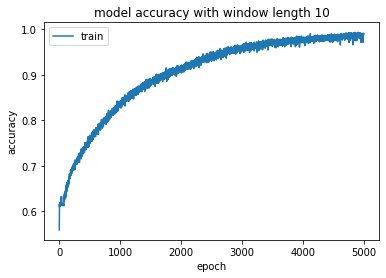

In [73]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

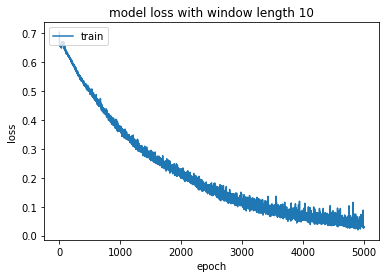

In [74]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [75]:
model.reset_states()
test_results = calc_pos_neg_rate(model.evaluate(x=test_generator, verbose=0))

In [76]:
model.reset_states()
train_results = calc_pos_neg_rate(model.evaluate(x=train_generator, verbose=0))

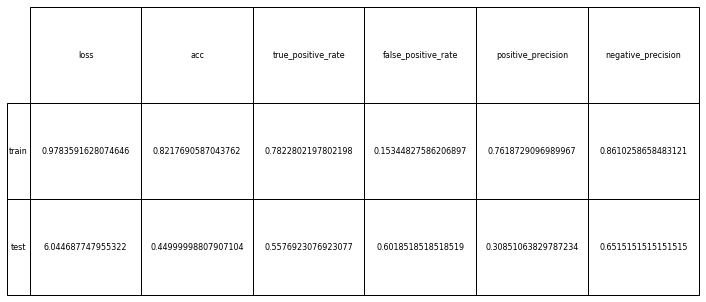

In [77]:
tabular_test_train_results(train_results, test_results)

Now, let's try window size of 20

In [135]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=20)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_56 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_14 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_57 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_14 (Batc (32, 16)                  64        
_________________________________________________________________
dense_58 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_59 (Dense)             (32, 1)                 

In [136]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.790 seconds , loss : 0.681    accuracy : 0.580    
epoch 2
----------->> Epoch 1/1   0.433 seconds , loss : 0.670    accuracy : 0.612    
epoch 3
----------->> Epoch 1/1   0.471 seconds , loss : 0.665    accuracy : 0.613    
epoch 4
----------->> Epoch 1/1   0.436 seconds , loss : 0.664    accuracy : 0.613    
epoch 5
----------->> Epoch 1/1   0.443 seconds , loss : 0.661    accuracy : 0.618    
epoch 6
----------->> Epoch 1/1   0.405 seconds , loss : 0.660    accuracy : 0.618    
epoch 7
----------->> Epoch 1/1   0.397 seconds , loss : 0.656    accuracy : 0.618    
epoch 8
----------->> Epoch 1/1   0.379 seconds , loss : 0.661    accuracy : 0.620    
epoch 9
----------->> Epoch 1/1   0.394 seconds , loss : 0.670    accuracy : 0.614    
epoch 10
----------->> Epoch 1/1   0.419 seconds , loss : 0.669    accuracy : 0.614    
epoch 11
----------->> Epoch 1/1   0.385 seconds , loss : 0.668    accuracy : 0.614    
epoch 12
----------->> Epoch 1/1   0.401 

----------->> Epoch 1/1   0.400 seconds , loss : 0.581    accuracy : 0.712    
epoch 187
----------->> Epoch 1/1   0.429 seconds , loss : 0.578    accuracy : 0.705    
epoch 188
----------->> Epoch 1/1   0.401 seconds , loss : 0.579    accuracy : 0.704    
epoch 189
----------->> Epoch 1/1   0.406 seconds , loss : 0.576    accuracy : 0.712    
epoch 190
----------->> Epoch 1/1   0.383 seconds , loss : 0.574    accuracy : 0.713    
epoch 191
----------->> Epoch 1/1   0.397 seconds , loss : 0.572    accuracy : 0.715    
epoch 192
----------->> Epoch 1/1   0.379 seconds , loss : 0.575    accuracy : 0.708    
epoch 193
----------->> Epoch 1/1   0.384 seconds , loss : 0.571    accuracy : 0.709    
epoch 194
----------->> Epoch 1/1   0.390 seconds , loss : 0.580    accuracy : 0.696    
epoch 195
----------->> Epoch 1/1   0.396 seconds , loss : 0.570    accuracy : 0.711    
epoch 196
----------->> Epoch 1/1   0.405 seconds , loss : 0.571    accuracy : 0.712    
epoch 197
----------->> Epoch 1

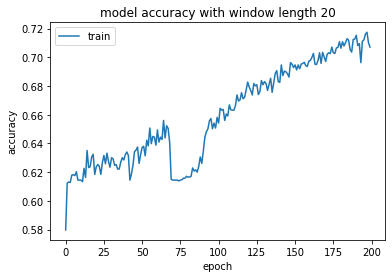

In [137]:
plt.plot(train_accs)
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

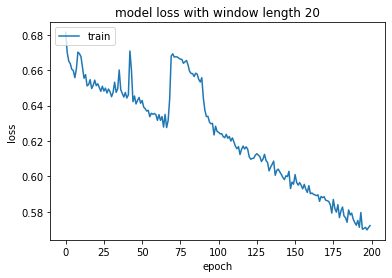

In [138]:
plt.plot(train_losses)
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [139]:
model.reset_states()
test_results = calc_pos_neg_rate(model.evaluate(x=test_generator, verbose=0))

In [140]:
model.reset_states()
train_results = calc_pos_neg_rate(model.evaluate(x=train_generator, verbose=0))

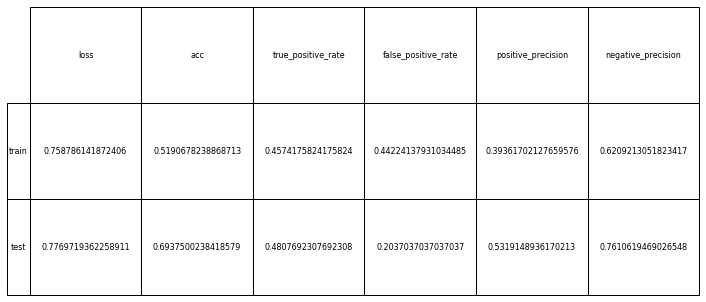

In [141]:
tabular_test_train_results(train_results, test_results)

Now, let's try window size of 30

In [142]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_60 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_15 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_61 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_15 (Batc (32, 16)                  64        
_________________________________________________________________
dense_62 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_63 (Dense)             (32, 1)                 

In [143]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.835 seconds , loss : 0.687    accuracy : 0.591    
epoch 2
----------->> Epoch 1/1   0.425 seconds , loss : 0.667    accuracy : 0.614    
epoch 3
----------->> Epoch 1/1   0.404 seconds , loss : 0.666    accuracy : 0.613    
epoch 4
----------->> Epoch 1/1   0.424 seconds , loss : 0.663    accuracy : 0.615    
epoch 5
----------->> Epoch 1/1   0.440 seconds , loss : 0.660    accuracy : 0.621    
epoch 6
----------->> Epoch 1/1   0.417 seconds , loss : 0.660    accuracy : 0.622    
epoch 7
----------->> Epoch 1/1   0.426 seconds , loss : 0.658    accuracy : 0.621    
epoch 8
----------->> Epoch 1/1   0.418 seconds , loss : 0.659    accuracy : 0.627    
epoch 9
----------->> Epoch 1/1   0.408 seconds , loss : 0.662    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   0.421 seconds , loss : 0.671    accuracy : 0.615    
epoch 11
----------->> Epoch 1/1   0.408 seconds , loss : 0.669    accuracy : 0.614    
epoch 12
----------->> Epoch 1/1   0.398 

----------->> Epoch 1/1   0.398 seconds , loss : 0.667    accuracy : 0.614    
epoch 187
----------->> Epoch 1/1   0.409 seconds , loss : 0.667    accuracy : 0.614    
epoch 188
----------->> Epoch 1/1   0.416 seconds , loss : 0.667    accuracy : 0.614    
epoch 189
----------->> Epoch 1/1   0.423 seconds , loss : 0.667    accuracy : 0.614    
epoch 190
----------->> Epoch 1/1   0.420 seconds , loss : 0.667    accuracy : 0.614    
epoch 191
----------->> Epoch 1/1   0.420 seconds , loss : 0.667    accuracy : 0.614    
epoch 192
----------->> Epoch 1/1   0.423 seconds , loss : 0.667    accuracy : 0.614    
epoch 193
----------->> Epoch 1/1   0.417 seconds , loss : 0.667    accuracy : 0.614    
epoch 194
----------->> Epoch 1/1   0.421 seconds , loss : 0.667    accuracy : 0.614    
epoch 195
----------->> Epoch 1/1   0.423 seconds , loss : 0.667    accuracy : 0.614    
epoch 196
----------->> Epoch 1/1   0.418 seconds , loss : 0.665    accuracy : 0.614    
epoch 197
----------->> Epoch 1

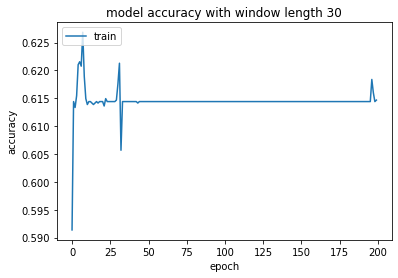

In [144]:
plt.plot(train_accs)
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

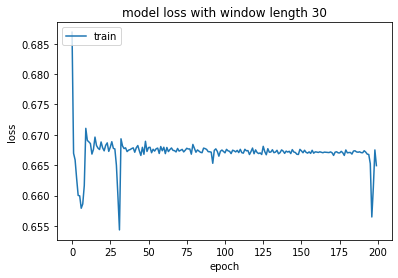

In [145]:
plt.plot(train_losses)
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [146]:
model.reset_states()
test_results = calc_pos_neg_rate(model.evaluate(x=test_generator, verbose=0))

ZeroDivisionError: float division by zero

In [77]:
model.reset_states()
train_results = calc_pos_neg_rate(model.evaluate(x=train_generator, verbose=0))

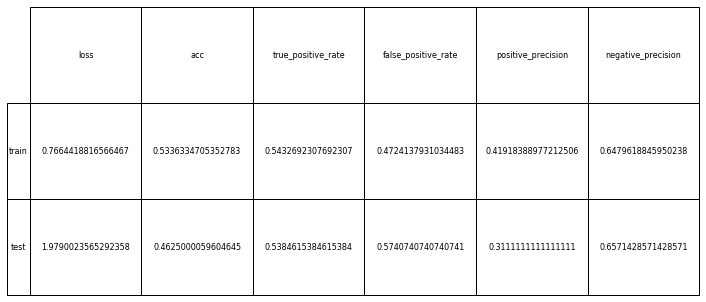

In [78]:
tabular_test_train_results(train_results, test_results)

Next, we train the model for 1200 epochs and save it for further use. This time, we have no validation and we train on the whole dataset.

In [ ]:
_training_end = pandas.to_datetime('20200501', format='%Y%m%d', errors='ignore')

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,training_data.shape[1], training_data.shape[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]


train_generator, _ = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, _training_end, None, None, test_required=False)
metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(train_generator.dim, optimizer, layers, metrics=metrics)
model.summary()

In [ ]:
epochs = 1200
fit(model, epochs, train_generator)

In [ ]:
model.save(join(COLAB_DIR,'model_stateful.h5'))

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model

In [ ]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]

In [ ]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Next, we load the pretrained model

In [ ]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [ ]:
from keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model.h5'))
base_model.summary()

In [ ]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

In [ ]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
results = calc_neg_pos_rate(base_model.evaluate(x=test_generator))
print('test:', results)

In [ ]:
results = calc_neg_pos_rate(base_model.evaluate(x=train_generator))
print('train:', results)